# Importing the Data

In [3]:
from zipfile import ZipFile
with ZipFile('../Data/Zips/barcelona-airbnb-listings-inside-airbnb.zip', 'r') as zipObj:
   zipObj.extractall(path="../Data/Content/AirBnB")
   print("done")

done


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_csv('../Data/Content/AirBnB/Cleaned_airbnb_barcelona.csv')

In [6]:
df.head(2)

,Unnamed: 0,id,host_id,host_is_superhost,host_listings_count,neighbourhood,zipcode,latitude,longitude,property_type,...,amenities,price,minimum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews_ltm,review_scores_rating
0,0,18666,71615,f,45.0,Sant Martí,8026,41.40889,2.18555,Apartment,...,"['TV', 'Internet', 'Wifi', 'Air conditioning',...",$130.00,3,t,0,0,0,182,0,80.0
1,1,18674,71615,f,45.0,La Sagrada Família,8025,41.40420,2.17306,Apartment,...,"['TV', 'Internet', 'Wifi', 'Air conditioning',...",$60.00,1,t,3,20,50,129,10,87.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19833 entries, 0 to 19832
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             19833 non-null  int64  
 1   id                     19833 non-null  int64  
 2   host_id                19833 non-null  int64  
 3   host_is_superhost      19799 non-null  object 
 4   host_listings_count    19799 non-null  float64
 5   neighbourhood          19823 non-null  object 
 6   zipcode                19229 non-null  object 
 7   latitude               19833 non-null  float64
 8   longitude              19833 non-null  float64
 9   property_type          19833 non-null  object 
 10  room_type              19833 non-null  object 
 11  accommodates           19833 non-null  int64  
 12  bathrooms              19824 non-null  float64
 13  bedrooms               19830 non-null  float64
 14  beds                   19799 non-null  float64
 15  am

In [8]:
need = ['host_is_superhost', 'latitude','longitude', 'property_type',
        'room_type', 'accommodates', 'bathrooms','bedrooms', 'beds', 'amenities', 'price',
        'minimum_nights','review_scores_rating']

clean = df[need]

In [9]:
clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19833 entries, 0 to 19832
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   host_is_superhost     19799 non-null  object 
 1   latitude              19833 non-null  float64
 2   longitude             19833 non-null  float64
 3   property_type         19833 non-null  object 
 4   room_type             19833 non-null  object 
 5   accommodates          19833 non-null  int64  
 6   bathrooms             19824 non-null  float64
 7   bedrooms              19830 non-null  float64
 8   beds                  19799 non-null  float64
 9   amenities             19833 non-null  object 
 10  price                 19833 non-null  object 
 11  minimum_nights        19833 non-null  int64  
 12  review_scores_rating  14986 non-null  float64
dtypes: float64(6), int64(2), object(5)
memory usage: 2.0+ MB


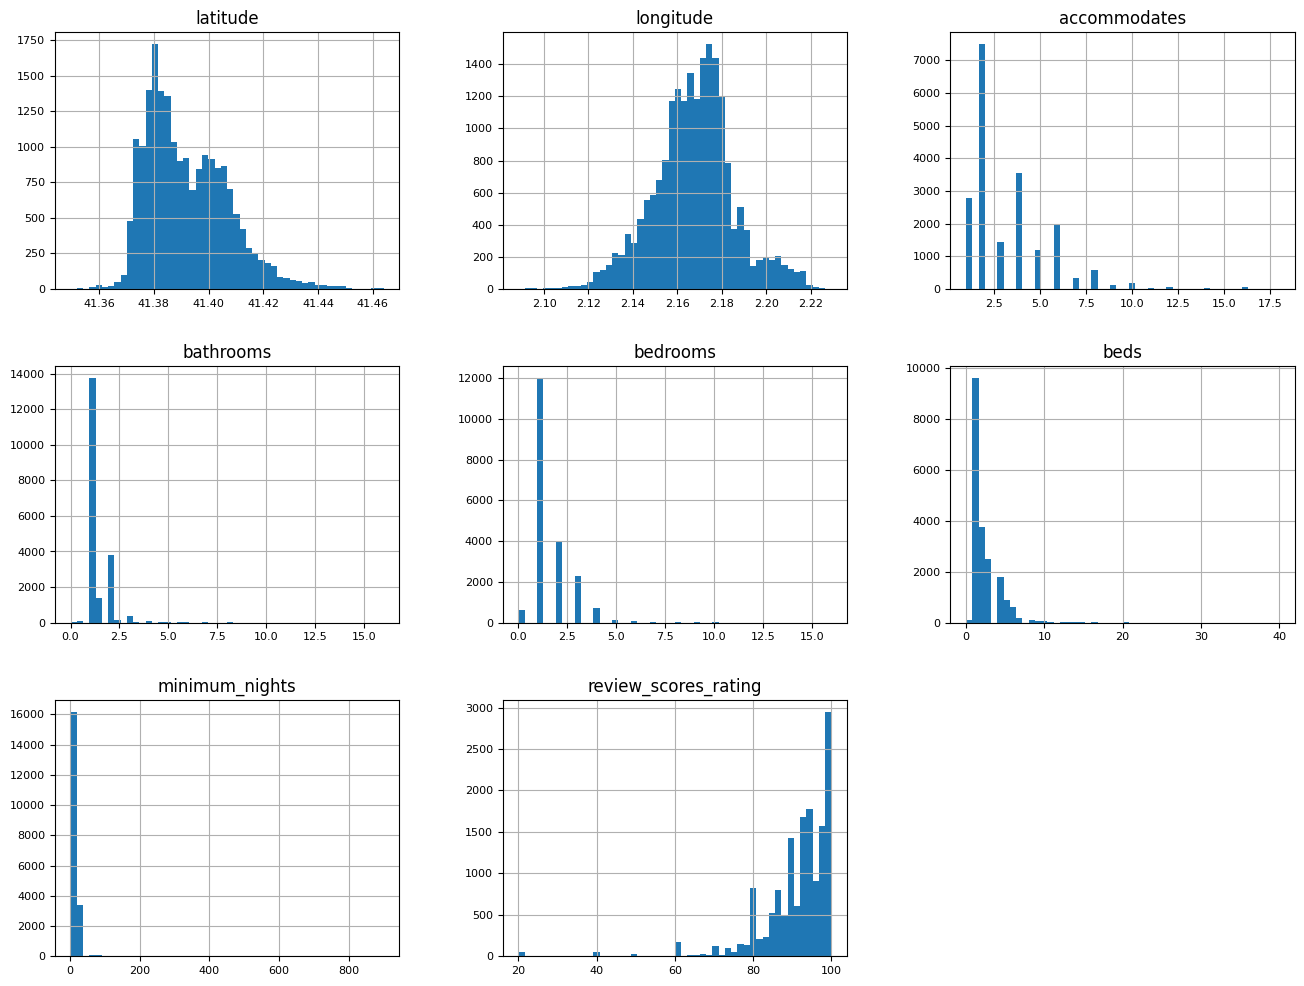

In [10]:
nums = clean.select_dtypes(include=np.number)
nums.hist(figsize=(16, 12), bins=50, xlabelsize=8, ylabelsize=8);

The aim of this model is to try and predict the price of the house on Air BNB barcelona

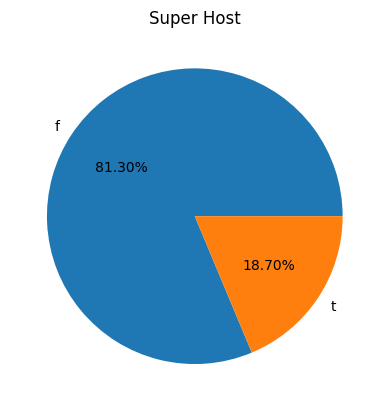

In [11]:
sns.color_palette("bright")
data = clean["host_is_superhost"].value_counts()
plt.pie(x=data, labels=data.index, autopct="%.2f%%")
plt.title("Super Host")
plt.show()

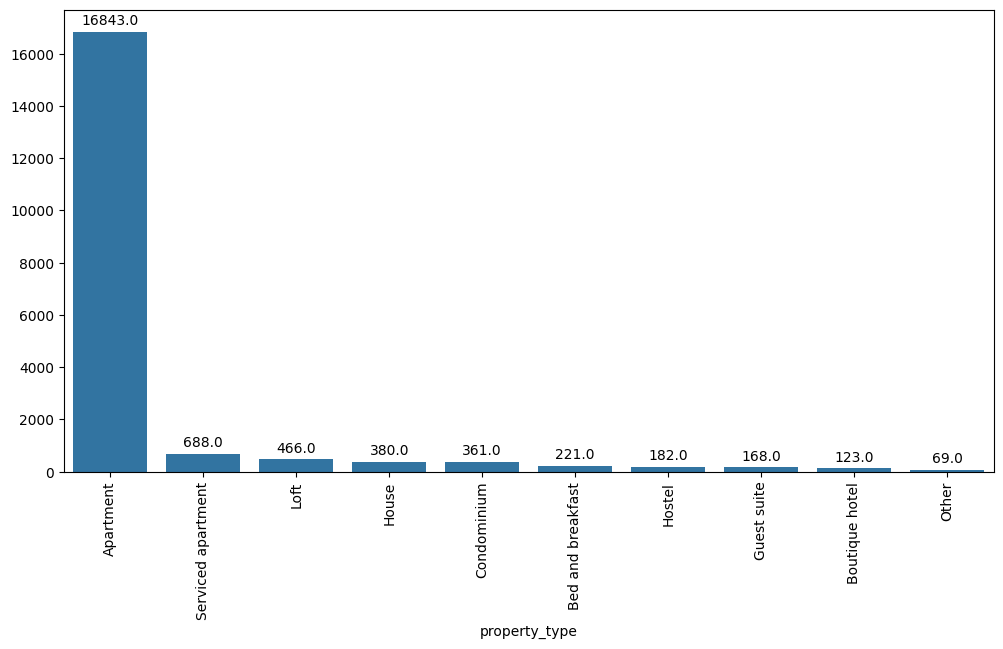

In [12]:
data = clean["property_type"].value_counts()
data = data.iloc[:10]
plt.figure(figsize=(12,6))
plots = sns.barplot(x=data.index, y=data.values)
for bar in plots.patches:
  plots.annotate(format(bar.get_height(), ''),
                 (bar.get_x() + bar.get_width() / 2,
                  bar.get_height()), ha='center', va='center',
                 size=10, xytext=(0, 8),
                 textcoords='offset points')
plt.xticks(rotation=90)
plt.show()

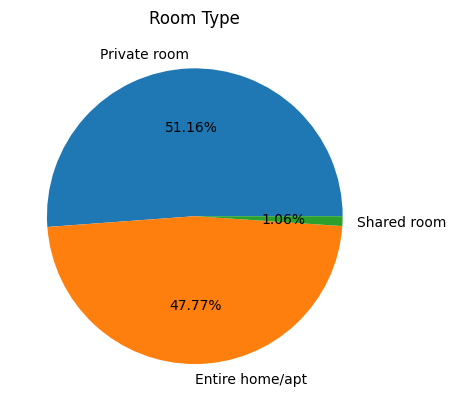

In [13]:
data = clean["room_type"].value_counts()
plt.pie(x=data, labels=data.index, autopct="%.2f%%")
plt.title("Room Type")
plt.show()

In [14]:
data = clean["price"]
data.head(2)

0    $130.00
1     $60.00
Name: price, dtype: object

In [15]:
import re
numbers = re.compile(r'[\D]')
clean.loc[:,"price"] = data.apply(lambda x: float(numbers.sub('', x)) / 100)

<Axes: xlabel='price', ylabel='Count'>

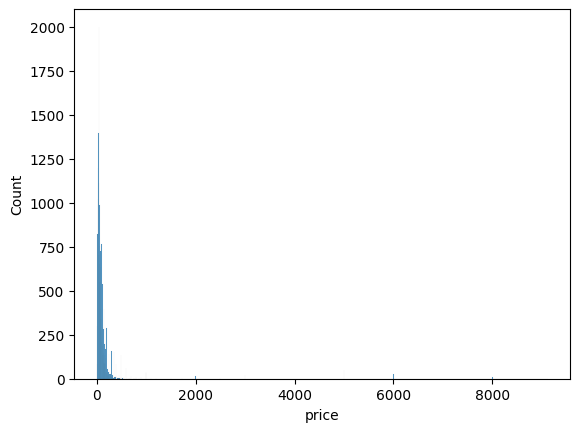

In [16]:
sns.histplot(x="price", data=clean)

In [17]:
clean["amenities"].iloc[0][1:-1].split(",")

["'TV'",
 " 'Internet'",
 " 'Wifi'",
 " 'Air conditioning'",
 " 'Wheelchair accessible'",
 " 'Kitchen'",
 " 'Elevator'",
 " 'Free street parking'",
 " 'Heating'",
 " 'Family/kid friendly'",
 " 'Washer'",
 " 'Dryer'",
 " 'Essentials'",
 " 'Shampoo'",
 " 'Hair dryer'",
 " 'Hot water'",
 " 'Host greets you'",
 " 'Paid parking on premises'"]

In [18]:
from sklearn.base import BaseEstimator, TransformerMixin
from collections import Counter

class Feature_OneHot(BaseEstimator, TransformerMixin):
    def __init__(self, max_features: int = 10):
        self.max_features = max_features

    def fit(self, X, y=None):
        X = X.values if isinstance(X, pd.DataFrame) else X
        counter = Counter()

        for row in X:
            data = self._process_row(row)
            counter.update(data)

        self.feature_name_ = {i: x[0] for i, x in enumerate(counter.most_common(self.max_features))}
        self.feature_count_ = dict(counter.most_common(self.max_features))
        self.feature_count_["other"] = sum(counter.values()) - sum(self.feature_count_.values())
        return self

    def transform(self, X, y=None):
        X = X.values if isinstance(X, pd.DataFrame) else X
        mat = []
        feature_set = set(self.feature_name_.values())

        for row in X:
            dict_ = {feature: 0 for feature in self.feature_name_.values()}
            dict_["other"] = 0
            data = self._process_row(row)

            for item in data:
                if item in feature_set:
                    dict_[item] += 1
                else:
                    dict_["other"] += 1

            mat.append(list(dict_.values()))

        return np.array(mat)

    @staticmethod
    def _process_row(row):
        if isinstance(row, str):
            data = row[1:-1].split(',')
        elif isinstance(row, np.ndarray):
            data = row[0][1:-1].split(',')
        else:
            raise ValueError("Unsupported input type")

        return [x.strip("' ").lower() for x in data]

In [19]:
f_one = Feature_OneHot()
d = f_one.fit_transform(clean["amenities"])

In [20]:
f_one.feature_name_

{0: 'wifi',
 1: 'essentials',
 2: 'kitchen',
 3: 'hangers',
 4: 'hair dryer',
 5: 'washer',
 6: 'heating',
 7: 'iron',
 8: 'tv',
 9: 'shampoo'}

In [21]:
d[0]

array([ 1,  1,  1,  0,  1,  1,  1,  0,  1,  1, 10])

In [22]:
nums.skew()

latitude                 0.805256
longitude                0.000257
accommodates             1.656622
bathrooms                4.051245
bedrooms                 2.143099
beds                     3.435190
minimum_nights          12.240694
review_scores_rating    -2.867834
dtype: float64

In [23]:
skews = ["accommodates", "bathrooms", "bedrooms", "beds", "review_scores_rating"]
outliers = ["minimum_nights"]

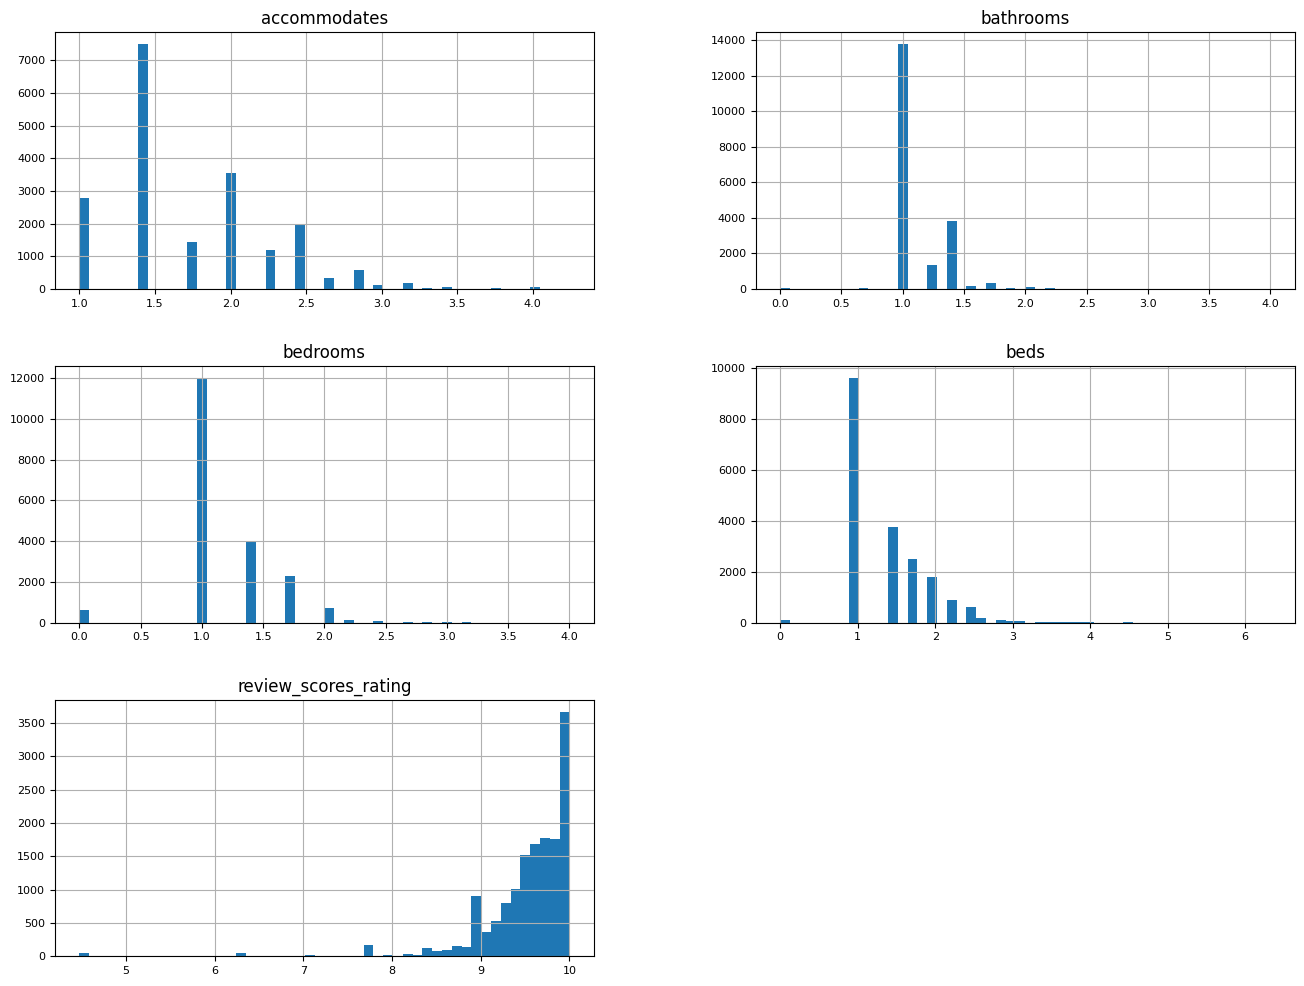

In [24]:
nums[skews].apply(lambda x: np.sqrt(x)).hist(figsize=(16, 12), bins=50, xlabelsize=8, ylabelsize=8);

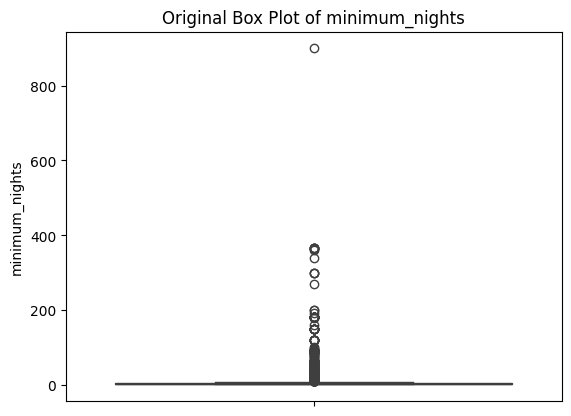

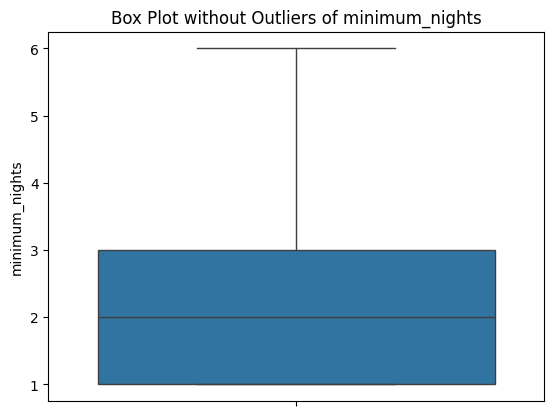

In [25]:
def removal_box_plot(df, column, threshold):
	sns.boxplot(df[column])
	plt.title(f'Original Box Plot of {column}')
	plt.show()

	removed_outliers = df[df[column] <= threshold]

	sns.boxplot(removed_outliers[column])
	plt.title(f'Box Plot without Outliers of {column}')
	plt.show()
	return removed_outliers


threshold_value = 6

no_outliers = removal_box_plot(clean, 'minimum_nights', threshold_value)

In [26]:
no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15857 entries, 0 to 19832
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   host_is_superhost     15830 non-null  object 
 1   latitude              15857 non-null  float64
 2   longitude             15857 non-null  float64
 3   property_type         15857 non-null  object 
 4   room_type             15857 non-null  object 
 5   accommodates          15857 non-null  int64  
 6   bathrooms             15849 non-null  float64
 7   bedrooms              15854 non-null  float64
 8   beds                  15824 non-null  float64
 9   amenities             15857 non-null  object 
 10  price                 15857 non-null  object 
 11  minimum_nights        15857 non-null  int64  
 12  review_scores_rating  13143 non-null  float64
dtypes: float64(6), int64(2), object(5)
memory usage: 1.7+ MB


# Pipelines

In [27]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer

In [28]:
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10,
                              random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [29]:
cat_cols = ["host_is_superhost", "property_type", "room_type"]

In [30]:
num_pipeline = make_pipeline(SimpleImputer(strategy="mean"),
                             FunctionTransformer(np.sqrt, feature_names_out="one-to-one"),
                             StandardScaler())

cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"),
                             OneHotEncoder(handle_unknown="ignore", max_categories=10))

amm_pipeline = make_pipeline(Feature_OneHot(max_features=20))

cluster_simil = make_pipeline(SimpleImputer(strategy="median"),
                              ClusterSimilarity(n_clusters=3, gamma=1., random_state=4))

preprocessing = ColumnTransformer([
    ("nums", num_pipeline, skews + outliers),
    ("cat", cat_pipeline, cat_cols),
    ("amm", amm_pipeline, ["amenities"]),
    ("geo", cluster_simil, ["latitude", "longitude"]),
])

In [ ]:
t = preprocessing.fit_transform(no_outliers)
t.shape

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(t, no_outliers["price"], test_size=0.2, random_state=42)

In [33]:
import tensorflow as tf
from tensorflow import keras

In [34]:
# norm_layer = keras.layers.Normalization()
# norm_layer.adapt(X_train)

# from functools import partial

# # RegularizedDense = partial(tf.keras.layers.Dense, activation="relu",
# #                            kernel_initializer="he_normal", kernel_regularizer=tf.keras.regularizers.l2(0.01))

# model = keras.models.Sequential([
#     keras.layers.Input(shape=(X_test.shape[1],)),
#     norm_layer,
#     RegularizedDense(128),
#     keras.layers.Dropout(0.5),
#     RegularizedDense(64),
#     keras.layers.Dropout(0.5),
#     RegularizedDense(32),
#     keras.layers.Dropout(0.5),
#     RegularizedDense(1)
# ])

In [42]:
input = keras.layers.Input(shape=(X_test.shape[1],))
hidden_1_d = keras.layers.Dense(128, activation="relu")(input)
drop_1 = keras.layers.Dropout(0.5)(hidden_1_d)
hidden_2_d = keras.layers.Dense(64, activation="relu")(drop_1)
drop_2 = keras.layers.Dropout(0.5)(hidden_2_d)
hidden_3_d = keras.layers.Dense(32, activation="relu")(drop_2)
drop_3 = keras.layers.Dropout(0.5)(hidden_3_d)
dense_4_d = keras.layers.Dense(1)(drop_3)

hidden_1_b = keras.layers.Dense(128, activation="relu")(input)
batch_1 = keras.layers.BatchNormalization()(hidden_1_b)
hidden_2_b = keras.layers.Dense(64, activation="relu")(batch_1)
batch_2 = keras.layers.BatchNormalization()(hidden_2_b)
hidden_3_b = keras.layers.Dense(32, activation="relu")(batch_2)
batch_3 = keras.layers.BatchNormalization()(hidden_3_b)
dense_4_b = keras.layers.Dense(1)(batch_3)

output = keras.layers.Average()([dense_4_d, dense_4_b])
# output = keras.layers.Dense(1)(concat)

model = keras.models.Model(inputs=[input], outputs=[output])


In [43]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 45)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 128)       │      5,888 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 128)       │      5,888 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_13[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │      8,256 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 64)        │      8,256 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_14[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 32)        │      2,080 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 32)        │      2,080 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 32)        │          0 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_15[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 1)         │         33 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 1)         │         33 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average (Average)   │ (None, 1)         │          0 │ dense_12[0][0],   │
│                     │                   │            │ dense_16[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,410 (130.51 KB)

 Trainable params: 32,962 (128.76 KB)

 Non-trainable params: 448 (1.75 KB)

In [44]:
model.compile(loss=keras.losses.Huber(),
              optimizer=keras.optimizers.Adam(1e-3),
              metrics=[keras.metrics.MeanAbsoluteError(name='mae'),
                       keras.metrics.MeanSquaredError(name='mse')])

In [45]:
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [46]:
X_train = np.asarray(X_train).astype('float32')
X_test = np.asarray(X_test).astype('float32')
y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')

history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
318/318 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 114.2519 - mae: 114.7496 - mse: 242846.5156 - val_loss: 73.4795 - val_mae: 73.9746 - val_mse: 155639.2656
Epoch 2/100
318/318 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 89.3198 - mae: 89.8160 - mse: 253443.2656 - val_loss: 71.7746 - val_mae: 72.2677 - val_mse: 154064.8906
Epoch 3/100
318/318 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 84.4402 - mae: 84.9353 - mse: 220280.2188 - val_loss: 70.1172 - val_mae: 70.6112 - val_mse: 151023.1719
Epoch 4/100
318/318 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 79.0020 - mae: 79.4979 - mse: 187929.3906 - val_loss: 69.2411 - val_mae: 69.7359 - val_mse: 149651.9219
Epoch 5/100
318/318 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 83.2326 - mae: 83.7280 - mse: 225347.6094 - val_loss: 70.2302 - val_mae: 70.7246 - val_mse: 151660.5781
Epoch 6/100
318/318 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 75.4551 - mae: 75.9494 - mse: 177789.0156 - val_loss: 68.6208 - val_mae: 69.1147 - val_mse: 148157.4219
Epoch 7

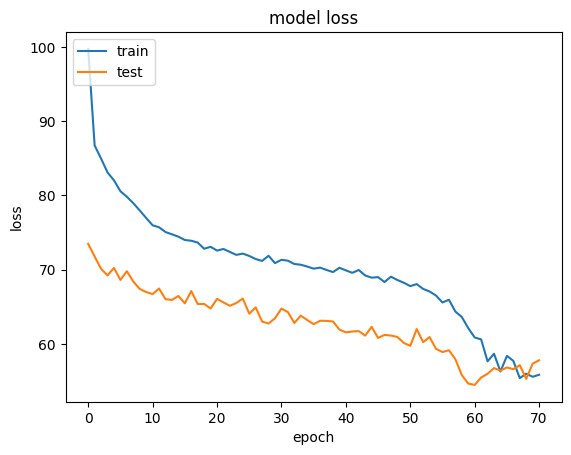

In [47]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Mean Squared Error: 63551.18359375
Mean Absolute Error: 56.31120300292969
R-squared: 0.5393596887588501


In [53]:
current_model = keras.models.load_model("../Models/Air-BnB.keras")
r2_c = r2_score(y_test, current_model.predict(X_test))
print(r2_c)
if r2 > r2_c:
    keras.models.save_model(model, filepath="../Models/Air-BnB.keras")

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
0.5393596887588501
